<a href="https://colab.research.google.com/github/RiceD2KLab/Audubon_F21/blob/SP22/Sp22_Audubon_Bird_Detection_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 Spring Houston Audubon Bird Detection Tutorial 
Authors: Wenbin Li, 

This is a colab tutorial of how to perform the data science pipelien for 10 bird detection from Houston Audubon. This work is after the cropping and spliting of the images into Train, Test and Validation folders.

## Installation and setup for Colab

Run the next cells to setup Colab with the necessary requirements. We clone the Github repo with the developed code, and install dependencies, namely Detectron2. 

In [ ]:
# Import some needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os, json, cv2, random
import sys, shutil, glob
from google.colab.patches import cv2_imshow
from skimage import io  
from datetime import datetime
from distutils.dir_util import copy_tree

In [ ]:
# This cell only excecutes if you're running on Colab. 
if 'google.colab' in sys.modules:
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  ################ Clone Audubon bird detection Github repo SP22 branch
  !git clone -b SP22 https://github.com/RiceD2KLab/Audubon_F21.git

  # Install dependencies 
  !pip install -qq pyyaml==5.1
  # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
  !pip install -qq torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

  # Install detectron2 that matches the above pytorch version
  # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
  !pip install -qq detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
  # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  !pip install -qq wandb

  # For AWS
  !pip install boto3
  # For hyperparameter tuning
  ! pip install optuna

Mounted at /gdrive/
Cloning into 'Audubon_F21'...
remote: Enumerating objects: 1666, done.
remote: Total 1666 (delta 0), reused 0 (delta 0), pack-reused 1666
Receiving objects: 100% (1666/1666), 61.50 MiB | 31.35 MiB/s, done.
Resolving deltas: 100% (1004/1004), done.
     |████████████████████████████████| 274 kB 5.1 MB/s 
     |████████████████████████████████| 831.4 MB 2.9 kB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/exceptions.py", line 7, in <module>
    from pip._vendor.pkg_

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 210 kB 44.7 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 113 kB 58.7 MB/s 
     |████████████████████████████████| 146 kB 48.7 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=10ed02174f0d2422b97d43e36f5b07a41778cd6c7ad7199ec56e80f2b9d4caa6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


### Load dataset from Google Drive 

This cell is an example to load pre split data into google colabs. Here we unzip google images from an example google drive and place them into Train, Test, Validation folders. This can be adapted for any drone images


In [ ]:
!mkdir -p './data'
# For public use
!pip install --upgrade --no-cache-dir gdown

!gdown -q https://drive.google.com/uc?id=1qmVP-zSK7Ew2QsjitAE2rFK5GwqRJcGR
!unzip -q './Validate.zip' -d './data'
!gdown -q https://drive.google.com/uc?id=1QzppZTelUfoxVFCh_eOEgp19PPsuYnCl
!unzip -q './Train.zip' -d './data'
!gdown -q https://drive.google.com/uc?id=1DAW8uAYJGhNFdFzDozs9GjiyVPBlK-3h
!unzip -q './Test.zip' -d './data'



## Data Wrangling

Converting the bbx files into csv readable files

In [ ]:
crop_dir = './data'
dirs = os.listdir(crop_dir)

# from Audubon_F21.utils.cropping_hank import csv_to_dict, dict_to_csv
from Audubon_F21.utils.cropping import csv_to_dict, dict_to_csv

for d in dirs:
    for f in glob.glob(os.path.join(crop_dir, d, '*.bbx')):
        dict_bird = csv_to_dict(f, annot_file_ext='bbx')
        dict_to_csv(dict_bird, os.path.split(f)[0], empty=False, img_ext='bbx')

/content/Audubon_F21/utils/cropping.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Data Exploration 

The following cells generate some metrics and plots to help understand the loaded dataset. 


 Train - Bird Species Distribution
Mixed Tern Adult                   5671
Laughing Gull Adult                2369
White Ibis Adult                    827
Black Skimmer Adult                 632
Reddish Egret Adult                 631
Roseate Spoonbill Adult             588
Brown Pelican Adult                 368
Tricolored Heron Adult              331
Great Blue Heron Adult              290
Black-Crowned Night Heron Adult     279
Name: class_name, dtype: int64




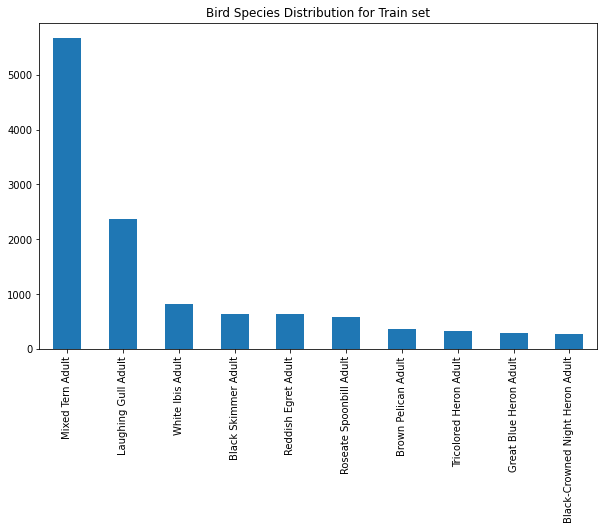


 Validate - Bird Species Distribution
Mixed Tern Adult                   1392
Laughing Gull Adult                 562
Black Skimmer Adult                 132
Brown Pelican Adult                  73
Tricolored Heron Adult               58
Black-Crowned Night Heron Adult      36
Reddish Egret Adult                  29
Roseate Spoonbill Adult              27
White Ibis Adult                     27
Great Blue Heron Adult               24
Name: class_name, dtype: int64




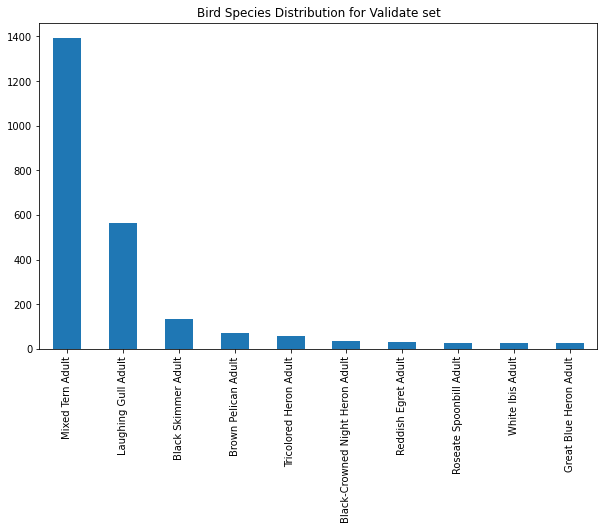


 Test - Bird Species Distribution
Mixed Tern Adult                   1233
Laughing Gull Adult                 556
Black Skimmer Adult                 123
Brown Pelican Adult                  66
Tricolored Heron Adult               59
Black-Crowned Night Heron Adult      35
White Ibis Adult                     33
Roseate Spoonbill Adult              27
Great Blue Heron Adult               22
Reddish Egret Adult                  22
Name: class_name, dtype: int64




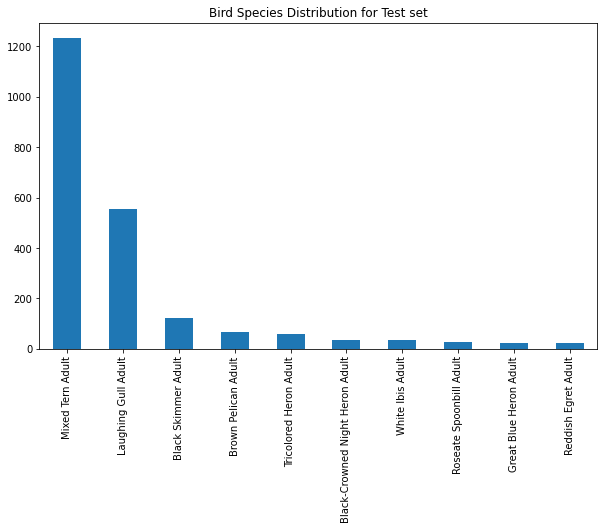

In [ ]:
# This cell plots the distribution of bird species contained in the entire dataset

# print the distribution of birds in each class
for d in dirs:
    target_data = []
    for f in glob.glob(os.path.join(crop_dir, d, '*.csv')):
        target_data.append(pd.read_csv(f, header=0,
                                       names=["class_id", "class_name", "x", "y", "width", "height"]))
    target_data = pd.concat(target_data, axis=0, ignore_index=True)

    # Visualize dataset
    print(f'\n {d} - Bird Species Distribution')
    print(target_data["class_name"].value_counts())
    print('\n')

    ax = target_data["class_name"].value_counts().plot.bar(x="Bird Species", y="Frequency",figsize=(10,6))  
    ax.set_title('Bird Species Distribution for '+ d +' set')
    plt.show()

Raw image with bounding boxes:


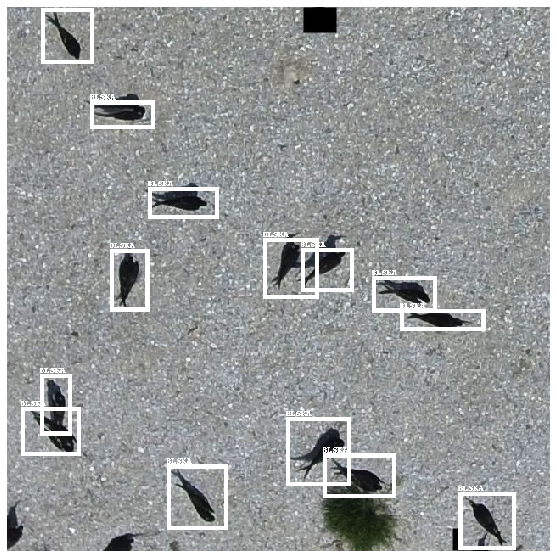

In [ ]:
# Show an example image of 640x640 with corresponding bounding boxes 
from PIL import Image 
from Audubon_F21.utils import plotting
from Audubon_F21.utils.cropping import csv_to_dict 

annot_dict = csv_to_dict(csv_path = './data/Test/102741 00008.bbx', annot_file_ext='bbx')
annotation_lst = [list(x.values()) for x in annot_dict['bbox']]

image_file = './data/Test/102741 00008.JPG'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
print("Raw image with bounding boxes:")
plotting.plot_img_bbx(image, annotation_lst)

### Perform data augmentation

Here are targeting the low count species and increasing the count by peroforming data augmentation. The allowed image augmentation is flipping, rotating and contrast changing. 

In [ ]:
import shutil
from Audubon_F21.utils.augmentation import AugTrainingSet, dataset_aug

# # dst_dir is the folder of training data(only after cropping)
dst_dir = crop_dir + '/Train'
# aug_dir is where we put image after doing data augmentation
os.makedirs('./temp', exist_ok=True)
aug_dir = './temp'
#
#
# # Minimum portion of a bounding box being accepted in a subimage
overlap = 0.2
#
# # List of species that we want to augment (PLEASE include the full name)
minor_species = ["REEGA","WHIBA","ROSPA", "BRPEA", "TRHEA"]
#
# # Threshold of non-minor creatures existing in a subimage
thres = .3

#[horizontal filp, vertical flip, left rotate, right rotate, [brightness/contrast tunning, number of images produced]]
aug_command = [1,1,1,0,[1,2]]

dataset_aug(dst_dir, aug_dir, minor_species, overlap, thres,
            aug_command, img_ext = 'JPG',annot_file_ext='csv',crop_height=640, crop_width=640)
# #
# #
# """"""
aug_list = glob.glob(os.path.join(aug_dir, '*'))
# print(aug_list)
# #
# print(dst_dir)

for i in aug_list:

    shutil.copy2(i, dst_dir)  # copy files from aug_list(certain files in aug_dir) to dst_dir (train data set)
    # print(i)

Aug_files: 100%|██████████| 2118/2118 [05:13<00:00,  6.76it/s]


## Modeling 

The primary models used to for object detection and classification from done images is Faster Region-Based Convolutional Neural Network (FASTER-RCNN). To implement this we utilized [Detectron2](https://github.com/facebookresearch/detectron2.git). This is Facebook research package. 



### Registering the dataset into Detectron2 

The following cell registers the training, validation, and testing datasets with Detectron2's dataset catalogs.


In [ ]:
from Audubon_F21.utils.dataloader import register_datasets

data_dir = crop_dir
img_ext = '.JPG'
dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir)]

# Bird species used by object detector. Species contained in dataset that are
# not contained in this list will be categorized as an "Unknown Bird"
BIRD_SPECIES = ["BCNHA", "BLSKA", "BRPEA", "LAGUA", "REEGA",
                'ROSPA', 'MTRNA', 'SATEA', 'TRHEA',
                'WHIBA']

birds_species_names = BIRD_SPECIES

SPECIES_MAP = {0: 'BCNHA', 1: 'BLSKA', 2: 'BRPEA',
               3: 'LAGUA', 4: 'REEGA', 5: 'ROSPA',
               6: 'MTRNA', 7: 'GBHEA', 8: 'TRHEA', 9: 'WHIBA'}

# Bounding box colors for bird species (used when plotting images)
BIRD_SPECIES_COLORS = []
#
register_datasets(dirs, img_ext, BIRD_SPECIES, bird_species_colors=BIRD_SPECIES_COLORS, unknown_bird_category=False)


### Training 

The following cells train a RetinaNet and Faster R-CNN model with a ResNet-50 FPN backbone. The model weights are initialized from a model pretrained on the MS COCO dataset. The training loop is based on Detectron2's Default Trainer.  Hyperparameters can be tweaked! 

#### Bird species 

The bird species model both localizes and classifies bird species. We registered the species to be classifed in the above dataloader (see BIRD_SPECIES list). We utilize Faster R-CNN for better performance. 

In [ ]:
# importing the hyperparameter tuning package
! pip install optuna

In [ ]:
# # # # training the bird species model using Faster R-CNN
custom_weight = []

#name of the model output
model_output_dir = './Training_models/04_28_10class_aug_T2'

# model parameters
cfg_parms = {'NUM_WORKERS': 0, 'IMS_PER_BATCH': 6, 'BASE_LR': .001, 'GAMMA': 0.01,
             'WARMUP_ITERS': 1, 'MAX_ITER': 800,
             'STEPS': [499], 'CHECKPOINT_PERIOD': 499, 'output_dir': model_output_dir,
             'model_name': "faster_rcnn_R_50_FPN_1x", 'BIRD_SPECIES': BIRD_SPECIES, 'Custom': False}

from Audubon_F21.utils.hyperparameter import main_hyper, main_fit

# hyperparameter tunning
tuned_cfg_params = main_hyper(cfg_parms, iterations=2)
tuned_cfg_params['MAX_ITER'] = tuned_cfg_params['MAX_ITER'] + 100
tune_weight_dir, loss = main_fit(tuned_cfg_params)

ModuleNotFoundError: ignored

### Evaluation

The following cell outputs various evaluation metrics, plots, and images. Please read more about the [COCO evaluation metrics](https://cocodataset.org/#detection-eval) to understand how the AP metrics are calculated. 

In [ ]:
# for example only: loading a pretrained weight from 

!gdown -q https://drive.google.com/uc?id=11gWOyrHCp4QJgRKI_5wFzVL3kF38d7JX
!unzip -q './model_final.zip' -d './'

tune_weight_dir = './'

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from Audubon_F21.utils.evaluation import plot_precision_recall
from Audubon_F21.utils.evaluation import get_precisions_recalls
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

cfg = get_cfg()

# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(tune_weight_dir, 'model_final.pth')
predictor = DefaultPredictor(cfg)

# printing the precision and recall curves for each of the bird species with an IoU of 0.5
print('test inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_Test")
plot_precision_recall(val_precisions, val_max_recalls, BIRD_SPECIES,
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

RuntimeError: ignored

## Extracting the confusion matrix

Here, an IoU threshold of 0.5 is used and the confusion matrix and the classification report is shown on how well the model is performing

In [ ]:
rom utils.dataloader import get_bird_species_dicts
from detectron2.data import DatasetCatalog

from utils.confusion_matrix_birds import confusion_matrix_report

# registering the test dataset
d = 1


train_set_dir = crop_dir + '\Test'
DatasetCatalog.register('test_set', lambda d=d: get_bird_species_dicts(train_set_dir, birds_species_names,
                                                                       img_ext='.JPG', unknown_bird_category=True))

data = DatasetCatalog.get("test_set")

# grab the confusion matrix
pred_total, truth_total = confusion_matrix_report(data, predictor, birds_species_names, img_ext='JPG')
#
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(truth_total, pred_total))
print(classification_report(truth_total, pred_total))

## Running trained model on dataset

The following cells run a pretrained model on a dataset containing only raw images. It generates an output csv file containing the predicted bounding boxes after non-maximal suppression. 


### Tiling

The tiling step in the detection pipeline is done using a sliding window. The sub-images are deliberately generated to have a significant proportion of overlapping with adjacent sub-images. The level of overlapping can be specified by setting a parameter. The reason why we want to have the overlapping is because we can ensure that there is at least one complete version of each bird in one of the sub-images. We then try to eliminate overlapping predicted bounding boxes for the same bird by using non-maximum suppression.



In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_img_only


# # perform tiling on images 8K images
data_dir = 'C://Users\\VelocityUser\Documents\\D2K TDS B\\AI QC B'  # data directory folder
os.makedirs(os.getcwd() + '/AI_QC_test/crop', exist_ok=True)
output_dir = os.getcwd() + '/AI_QC_test/crop'
img_ext = '.JPG'
CROP_WIDTH = 640
CROP_HEIGHT = 640
SLIDING_SIZE = 400
crop_dataset_img_only(data_dir, img_ext, output_dir, crop_height=CROP_HEIGHT, crop_width=CROP_WIDTH,
                      sliding_size=SLIDING_SIZE)

### Run pipeline

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import evaluate_full_pipeline

# create list of tiled images to be run predictor on 
eval_file_lst = []
eval_file_lst = eval_file_lst + glob.glob('./data/crop/*.JPEG')

# Create detectron2 config and predictor 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# download model weights
!gdown -q https://drive.google.com/uc?id=1-f_INg5D0yG7AJUkuSJUcIl6BSaf-smR 
# load model weights 
cfg.MODEL.WEIGHTS = "./model_final.pth"

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES) 

# Create default predictor to run inference 
predictor = DefaultPredictor(cfg)
RAW_IMG_WIDTH = 8192
RAW_IMG_HEIGHT = 5460

# Run evaluation 
output_df = evaluate_full_pipeline(eval_file_lst, predictor, SPECIES_MAP, RAW_IMG_WIDTH, RAW_IMG_HEIGHT,
                           CROP_WIDTH, CROP_HEIGHT, SLIDING_SIZE)

### Download annotations as CSV file 


In [ ]:
from google.colab import files
output_df.to_csv('output.csv')
files.download('output.csv') 